# CNA PREP and RESULTS TISSUE CELLS
## Sid Gurajala
## 05/01/2023

## Libraries 

In [5]:
source("/data/srlab/ssg34/SLE_kidney_v2/scripts/libs/kidney_utils.r")
clinical <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/clinical_data_05042023.rds') %>% 
                        rename(Final_Site = Site) %>% select(-sample)

In [ ]:
#all_meta <- readRDS('/data/srlab2/qxiao/AMP-SLE/sc_nuc_data/20230215_Tissue/meta_Tissue_500nGene_1000nUMI_3pctnontargetMTwdoubletandsampleFINAL-02-22-23.rds')
norm <- readRDS('/data/srlab2/qxiao/AMP-SLE/sc_nuc_data/normalized_data_ScNuc_500nGene_1000nUMI_3pctnontargetMTwdoubletandsampleFINAL-8-10-22.rds')

In [ ]:
rawcounts <- readRDS('/data/srlab2/qxiao/AMP-SLE/sc_nuc_data/2022-08-09_ScNuc_cell_QCed_RawCounts.rds')
mito_genes_subset <- c("MT-ND5", "MT-ND6")
percent_mito <- colSums(rawcounts[mito_genes_subset, ]) / colSums(rawcounts) * 100
percent_mito <- data.frame(cell = names(percent_mito), percent.mt = percent_mito)

In [ ]:
saveRDS(percent_mito, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/percent_mito_from_rawcounts_12072023.rds')

In [ ]:
percent_mito <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/percent_mito_from_rawcounts_12072023.rds')

In [ ]:
kpmp_markers <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/KPMP_markers.csv')

# INTL

## SUBTYPING

In [ ]:
intl_meta <- readRDS('/data/srlab2/qxiao/AMP-SLE/sc_nuc_data/20230215_Tissue/INTL/2023-06-30_meta_500nGene_1000nUMI_3.rds')

In [ ]:
intl_meta <- intl_meta %>% filter(! hres.0.4 %in% c(9, 11))

In [ ]:
intl_meta$hres.0.4[intl_meta$hres.0.4 == 10] <- 9

In [ ]:
final_annotation = data.frame(hres.0.4 = factor(seq(0, 9)),
                                 final_annotation = c("INTL0. Fenestrated EC",
                                                      "INTL1. EC-AVR",
                                                      "INTL2. VSMC/P",
                                                      "INTL3. FIB",
                                                      "INTL4. EC-DVR",
                                                      "INTL5. EC-AEA",
                                                      "INTL6. EC-GLOM",
                                                      "INTL7. Mesangial",
                                                      "INTL8. EC/VSMC-P",
                                                      "INTL9. EC-LYMPH"))
intl_meta <- left_join(intl_meta, final_annotation)
cluster_center <- intl_meta %>%
                  group_by(hres.0.4) %>%
                  summarise_at(vars(huwotUMAP1, huwotUMAP2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)

In [ ]:
intl_meta <- left_join(intl_meta, percent_mito)

In [ ]:
saveRDS(intl_meta %>% select(-c(Annot.separate, predicted_broad, predicted_fine)),
        '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/intl_meta_qcd_harmony_umap_clusternames_11302023.rds')

In [ ]:
intl_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/intl_meta_qcd_harmony_umap_clusternames_11302023.rds')

In [ ]:
intl_norm <- norm[, intl_meta$cell]

In [ ]:
saveRDS(intl_norm, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/INTL_qcd_norm_12072023.rds')

In [28]:
qcd_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/intl_meta_qcd_harmony_umap_clusternames_11302023.rds')
qcd_meta <- qcd_meta %>% rename(new_cluster_number = hres.0.4)

In [29]:
sn_control <- qcd_meta %>% filter(dataset == "snRNAseq", Type == "Control") %>% 
                group_by(new_cluster_number) %>% 
                summarize(samples = length(unique(sample)),
                          ncells = length(unique(cell))) %>% 
                mutate(sn_control = paste0(samples, " (", ncells, ")")) %>% select(new_cluster_number, sn_control)
sn_LN <- qcd_meta %>% filter(dataset == "snRNAseq", Type == "LN") %>% 
                group_by(new_cluster_number) %>% 
                summarize(samples = length(unique(sample)),
                          ncells = length(unique(cell))) %>% 
                mutate(sn_LN = paste0(samples, " (", ncells, ")")) %>% select(new_cluster_number, sn_LN)
sc_control <- qcd_meta %>% filter(dataset == "scRNAseq", Type == "Control") %>% 
                group_by(new_cluster_number) %>% 
                summarize(samples = length(unique(sample)),
                          ncells = length(unique(cell))) %>% 
                mutate(sc_control = paste0(samples, " (", ncells, ")")) %>% select(new_cluster_number, sc_control)
sc_LN <- qcd_meta %>% filter(dataset == "scRNAseq", Type == "LN") %>% 
                group_by(new_cluster_number) %>% 
                summarize(samples = length(unique(sample)),
                          ncells = length(unique(cell))) %>% 
                mutate(sc_LN = paste0(samples, " (", ncells, ")")) %>% select(new_cluster_number, sc_LN)
merged <- sc_LN %>% left_join(sc_control) %>% left_join(sn_LN) %>% left_join(sn_control)
merged[is.na(merged)] <- "0 (0)"
write.csv(merged, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/INTL_summary_04152024.csv', quote = FALSE, row.names = FALSE)

Joining, by = "new_cluster_number"
Joining, by = "new_cluster_number"
Joining, by = "new_cluster_number"


### CLUSTERING/CELL STATE ASSIGNMENTS

In [8]:
intl_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/intl_meta_qcd_harmony_umap_clusternames_11302023.rds')
intl_norm <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/INTL_qcd_norm_12072023.rds')

In [ ]:
options(repr.plot.height = 8, repr.plot.width = 8)
ggplot() +
  geom_point(
    data=select(intl_meta, c(huwotUMAP1, huwotUMAP2, dataset)),
    aes(x = huwotUMAP1, y = huwotUMAP2),
    size = 0.1, stroke = 0.0001, color = "lightgrey"
  ) + 
  geom_point(
    data=intl_meta %>% filter(dataset == "scRNAseq") %>% select(huwotUMAP1, huwotUMAP2),
    aes(x = huwotUMAP1, y = huwotUMAP2),
    size = 0.1, stroke = 0.0001, color = "coral"
  ) +
theme_classic(base_size = 15) +
  theme(
    legend.position = "none",
        #  plot.title = element_text(hjust = 0.5, 
        #                            size = 18, 
        #                            face = "bold"),
          axis.title = element_text(hjust = 0.6, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +     labs(x = "UMAP1", y = "UMAP2") 

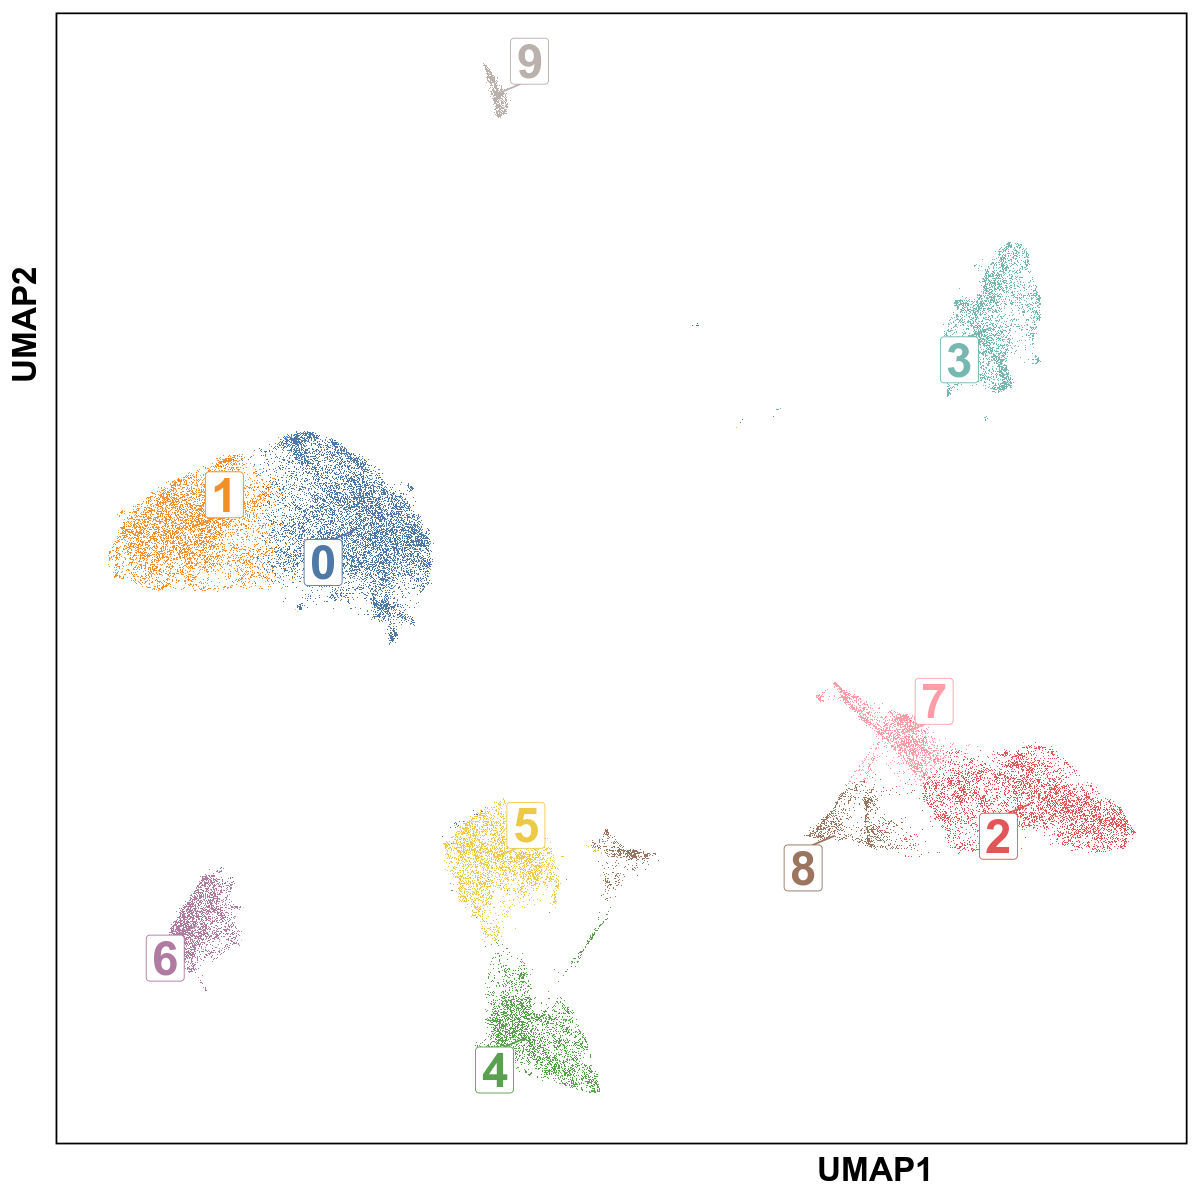

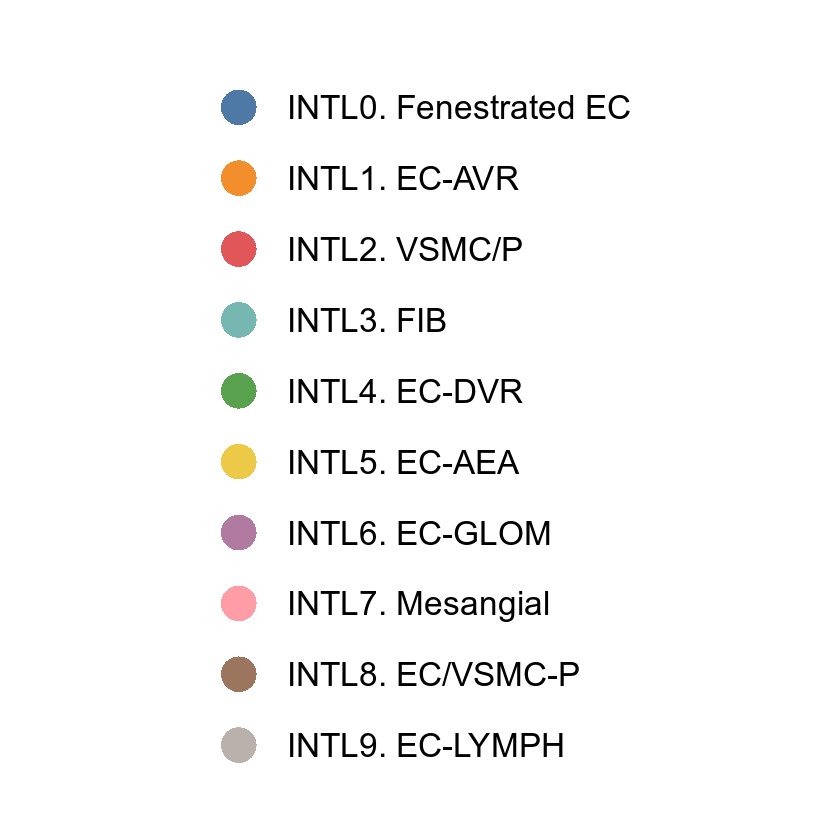

In [10]:
options(warn=-1)
cluster_center <- intl_meta %>%
                  group_by(hres.0.4, final_annotation) %>%
                  summarise_at(vars(huwotUMAP1, huwotUMAP2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)

options(repr.plot.height = 9, repr.plot.width = 18)
p <- ggplot() +
      geom_point(
        data = intl_meta[sample(nrow(intl_meta)), ] %>% 
          select(huwotUMAP1, huwotUMAP2, hres.0.4, final_annotation) %>% 
                  mutate(final_annotation = factor(final_annotation, 
                                                   levels = cluster_center$final_annotation)),
        aes(x = huwotUMAP1, y = huwotUMAP2, color = final_annotation),
          size = 0.25, shape = 20, stroke = 0.0001) +
      ggrepel::geom_label_repel(
        data = cluster_center,
        aes(x = huwotUMAP1, y = huwotUMAP2, 
            label = hres.0.4 , color = as.factor(final_annotation)),
        size = 10,  fontface = "bold",
        box.padding = unit(0.5, "lines"),
        point.padding = unit(0.01, "lines"),
        show.legend = FALSE
      ) +
    ggthemes::scale_color_tableau()   +
    theme_classic(base_size = 15) +
      theme(
        legend.position = "right",
            #  plot.title = element_text(hjust = 0.5, 
            #                            size = 18, 
            #                            face = "bold"),
              axis.title = element_text(hjust = 0.75, 
                                        size = 20, 
                                        face = "bold"), 
              axis.text = element_blank(),
              axis.line = element_blank(),
              axis.ticks = element_blank(),
              panel.border = element_rect(colour = "black", fill=NA, size=1),
              legend.text = element_text(size = 20),
              legend.title = element_blank()
          
    ) +
    theme(text=element_text(family="Arial")) + 
        labs(x = "UMAP1", y = "UMAP2") +
        guides(color = guide_legend(ncol = 1, override.aes = list(size = 15)))
legend <- cowplot::get_legend(p)
p <- p + theme(legend.position = "none")
legend <- cowplot::plot_grid(legend)
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/figure2/figure2g.png",
       p,
       base_height = 10,
       base_width = 10)
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/figure2/figure2g-legend.png",
       legend,
       base_height = 7,
       base_width = 7)
fig.size(10, 10)
p
fig.size(7, 7)
legend
options(warn=0)

In [ ]:
sc_de <- wilcoxauc(intl_norm[, intl_meta %>% filter(dataset == "scRNAseq") %>% pull(cell)], intl_meta %>% filter(dataset == "scRNAseq") %>% pull(hres.0.4)) 
sn_de <- wilcoxauc(intl_norm[, intl_meta %>% filter(dataset == "snRNAseq") %>% pull(cell)], intl_meta %>% filter(dataset == "snRNAseq") %>% pull(hres.0.4))

In [ ]:
sc_de %>% filter(group == 8, feature %in% extract_broad_genes("VSM/P")) %>% arrange(desc(logFC))

In [ ]:
sc_de %>% filter(group == 8, feature %in% extract_broad_genes("EC")) %>% arrange(desc(logFC))

In [ ]:
cluster_center <- intl_meta %>%
                  group_by(hres.0.4) %>%
                  summarise_at(vars(huwotUMAP1, huwotUMAP2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)

In [ ]:
fig.size(10, 12)
plot_shuffled_features(intl_meta, 
                       norm, 
                       "PLVAP", pct = 0.95) 

BTNL9, ADAMTS6, PALMD, AQP1, TM4SF1, 
0 - EC (AVR)
1 - VSM/P
2 - EC 
3 - FIB
4 - EC (GC)
5 - scublet_high
6 - EC (lymphatic)

In [ ]:
#BTNL9, ADAMTS6, PALMD, AQP1, TM4SF1, 
fig.size(8, 8)

plot_dist <- function(input_df, norm, feature)  {
    plot_df <- input_df %>% mutate(Exp = norm[feature, input_df$cell])
    p <- ggplot(plot_df, aes(x = hres.0.4, y = Exp, fill = dataset)) + 
            geom_violin(scale = "width") + 
            theme_classic(base_size = 20) + 
            labs(x = "Cluster", y = "Normalized Expression", title = feature) +
            theme(plot.title = element_text(size = 25, face = "bold.italic", hjust = 0.5))
    return(p)
}
#CEACAM1, DNASE1L3, PLVAP, GPM6A, EDIL3, TLL1, ZNF385D, NR2F2
#PITPNC1, GRB10, SLCO2A1, RAPGEF4
#NOTCH3, PDGFRB, ITGA8
#NTRK3, CCDC102B, RGS5, ABCC9, ADCY3, ADGRB3
#PIP5K1B, ROBO1, PIEZO2, DAAM2, PHTF2, GATA3, POSTN
#MCTP1, SLC14A1, ENPP2, LYPD6B
#BTNL9, ADAMTS6, PALMD, AQP1, TM4SF1, VEGFC, CCDC3, CDH5, SERPINE2, FBLN5, CXCL12, SOX17
#CEACAM1, DNASE1L3, PLVAP, PITPNC1, GRB10, SLCO2A1, RAPGEF4
#plot_dist(intl_meta, norm, "CEACAM1")
#plot_dist(intl_meta, norm, "DNASE1L3")
#plot_dist(intl_meta, norm, "PLVAP")
plot_dist(intl_meta, norm, "CEACAM1")
plot_dist(intl_meta, norm, "DNASE1L3")
plot_dist(intl_meta, norm, "PLVAP")
plot_dist(intl_meta, norm, "GRB10")
plot_dist(intl_meta, norm, "SLCO2A1")
plot_dist(intl_meta, norm, "RAPGEF4")

In [ ]:
plot_dist(intl_meta, norm, "CENPF")
plot_dist(intl_meta, norm, "EZH2")
plot_dist(intl_meta, norm, "APOLD1")

In [ ]:
write.csv(intl_de %>% rename(cluster = group), 
          '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/intl_de_wilcox_sc_sn_07242023.csv',
          row.names = FALSE, quote = FALSE)

In [ ]:
ggplot(intl_meta, 
       aes(x = as.factor(hres.0.4), y = as.numeric(doublet_score), fill = dataset)) + 
    geom_boxplot() + theme_classic(base_size = 20) + 
    labs(x = "cluster", y = "scrublet_score")




ggplot(intl_meta, 
       aes(x = as.factor(hres.0.4), y = log(as.numeric(nCount_RNA)), fill = dataset)) + 
    geom_boxplot() + theme_classic(base_size = 20) +
    labs(x = "cluster", y = "log(Counts Per Cell)")




ggplot(intl_meta,
       aes(x = as.factor(hres.0.4), y = log(as.numeric(nFeature_RNA)), fill = dataset)) + 
    geom_boxplot() + theme_classic(base_size = 20) + 
    labs(x = "cluster", y = "log(Genes Per Cell)")

### SC VS SN HEATMAP

In [8]:
intl_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/intl_meta_qcd_harmony_umap_clusternames_11302023.rds')
intl_norm <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/INTL_qcd_norm_12072023.rds')

In [ ]:
genes <- c("PECAM1", "PLVAP", "PTPRB", "FLT1", "CEACAM1", 
           "TLL1", "GPM6A",
           "MCAM", "NTRK3", "RGS5",
           "DCN", "COL1A2", "COL1A1",
           "LYPD6B", "ENPP2", "MCTP1",
           "ADAMTS6", "BTNL9", "CXCL12",
           'EMCN', 'HECW2', 'EHD3',
           'POSTN', "GATA3", "DAAM2", 
           "NOTCH3", "PDGFRB", 
           "MMRN1", "PROX1", "TBX1")

In [ ]:
sc_meta <- intl_meta %>% filter(dataset == "scRNAseq")
sc_de <- wilcoxauc(intl_norm[, sc_meta$cell], sc_meta$final_annotation)
sn_meta <- intl_meta %>% filter(dataset == "snRNAseq")
sn_de <- wilcoxauc(intl_norm[, sn_meta$cell], sn_meta$final_annotation)

In [ ]:
sc_plot_df <- sc_de %>%  filter(feature %in% genes) %>% 
                    select(group, feature, 
                           logFC, avgExpr, pct_in) %>% ungroup() %>% group_by(feature) %>% 
                    mutate(avgExpr_scaled = scale(avgExpr)) 
sn_plot_df <- sn_de %>%  filter(feature %in% genes) %>% 
                    select(group, feature, 
                           logFC, avgExpr, pct_in) %>% ungroup() %>% group_by(feature) %>% 
                    mutate(avgExpr_scaled = scale(avgExpr)) 

In [ ]:
range(sc_plot_df$avgExpr_scaled)
range(sn_plot_df$avgExpr_scaled)

In [ ]:
fig.size(10, 15)
ggplot(sc_plot_df %>% rename(percent = pct_in,
                             zscore = avgExpr_scaled), 
               aes(x = feature, y = group, 
                   fill = zscore)) + 
    geom_tile() + 
    theme_classic(base_size = 12) + 
    scale_fill_gradient2(low = "blue",
                         mid = "white",
                         high= "red", 
                         limits=c(-2, 2), 
                         oob = scales::squish) + 
    scale_x_discrete(limits = genes) + 
    scale_y_discrete(limits = final_annotation$final_annotation) + 
    theme(axis.text.x = element_text(angle = 90),
          axis.text = element_text(face = "bold", size = 15),
          axis.title = element_text(size = 15)) + 
    labs(x = "", y = "")
fig.size(10, 15)
ggplot(sn_plot_df %>% rename(percent = pct_in,
                             zscore = avgExpr_scaled), 
               aes(x = feature, y = group, 
                   fill = zscore)) + 
    geom_tile() + 
    theme_classic(base_size = 12) + 
    scale_fill_gradient2(low = "blue",
                         mid = "white",
                         high= "red", 
                         limits=c(-2, 2), 
                         oob = scales::squish) + 
    scale_x_discrete(limits = genes) + 
    scale_y_discrete(limits = final_annotation$final_annotation) + 
    theme(axis.text.x = element_text(angle = 90),
          axis.text = element_text(face = "bold", size = 15),
          axis.title = element_text(size = 15)) + 
    labs(x = "", y = "")

### SC VS SN FREQ

In [ ]:
intl_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/intl_meta_qcd_harmony_umap_clusternames_11302023.rds')
intl_meta <- intl_meta  %>% 
                mutate(hres.0.4 = factor(hres.0.4, levels = as.character(0:9))) %>% 
                mutate(individual = str_split(sample, '_')) %>% 
                rowwise() %>% 
                mutate(individual = unlist(individual)[3]) 

sample_freq <- intl_meta %>% select(dataset, individual, hres.0.4) %>% 
                    table() %>% data.frame() %>% 
                    pivot_wider(names_from = "hres.0.4", values_from = Freq) 

ind_list <- intl_meta %>% select(dataset, individual) %>% 
                table() %>% data.frame() %>% 
                pivot_wider(names_from = 'dataset', values_from = "Freq") %>% filter(scRNAseq > 100 & snRNAseq > 100) %>% 
                pull(individual)

sample_freq_sc <- sample_freq %>% 
                    filter(individual %in% ind_list) %>% 
                    select(- individual) %>% 
                    filter(dataset == "scRNAseq") %>% 
                    select(-dataset) %>% colSums()

sample_freq_sn <- sample_freq %>% 
                    filter(individual %in% ind_list) %>% 
                    select(- individual) %>% 
                    filter(dataset == "snRNAseq") %>% 
                    select(-dataset) %>% colSums()
sample_freq <- data.frame(rep("a", 10))
sample_freq$sc_freq <- sample_freq_sc / sum(sample_freq_sc)
sample_freq$sc_se <- sqrt((sample_freq$sc_freq * (1 - sample_freq$sc_freq)) / sample_freq_sc)
sample_freq$sn_freq <- sample_freq_sn / sum(sample_freq_sn)
sample_freq$sn_se <- sqrt((sample_freq$sn_freq * (1 - sample_freq$sn_freq)) / sample_freq_sn)
sample_freq <- sample_freq[,- 1]
sample_freq$hres.0.4 <- as.character(seq(0, 9))

fig.size(8, 8)

max_val <- max(sample_freq[, c("sc_freq", "sn_freq")])

ggplot(sample_freq, aes(x = sc_freq, y = sn_freq, color = hres.0.4)) + 
    geom_abline(linetype = "dashed") +
    ggthemes::scale_color_tableau(palette = "Tableau 10") +
    theme_classic() + 
    geom_point(size = 4) + 
    geom_linerange(aes(ymax = sn_freq+1.96*sn_se, 
                        ymin = sn_freq-1.96*sn_se), alpha = 0.5) +
    geom_linerange(aes(xmax = sc_freq+1.96*sc_se, 
                        xmin = sc_freq-1.96*sc_se), alpha = 0.5) +
    theme(legend.position = "none",
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 18)) +
    coord_cartesian(xlim = c(0, 0.4), ylim = c(0, 0.4)) + 
    labs(x = "scRNAseq",
         y = "snRNAseq")

In [ ]:
cor.test(sample_freq$sc_freq, sample_freq$sn_freq)

## CASE/CONTROL

In [ ]:
first_biop_pred <- readRDS("/data/srlab2/qxiao/AMP-SLE/data/clinical/df_pred_biop.rds") %>% 
                        mutate(individual = str_split(Subject_ID, '-')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2])


sc_meta <- intl_meta[, !colnames(intl_meta) %in% colnames(clinical)] %>% 
                        mutate(kid_sample = intl_meta$sample) %>% 
                        filter(dataset == 'scRNAseq') %>% 
                        mutate(individual = str_split(kid_sample, '_')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[3]) %>% 
                        left_join(clinical) %>% 
                        left_join(first_biop_pred) %>% 
                        select(c(cell, paste0('hPC-', 1:20), Sex, huwotUMAP1, huwotUMAP2, sample, final_annotation,
                                 Responder.Status, Age, Race, Final_ISN, Final_Chronicity, Final_Activity, Type, Final_Site,
                                 First_biop, Pred_use)) 

sn_meta <- intl_meta[, !colnames(intl_meta) %in% colnames(clinical)] %>% 
                        mutate(kid_sample = intl_meta$sample) %>% 
                        filter(dataset == 'snRNAseq') %>% 
                        mutate(individual = str_split(kid_sample, '_')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[3]) %>% 
                        left_join(clinical) %>% 
                        left_join(first_biop_pred) %>% 
                        select(c(cell, paste0('hPC-', 1:20), Sex, huwotUMAP1, huwotUMAP2, sample, final_annotation,
                                 Responder.Status, Age, Race, Final_ISN, Final_Chronicity, Final_Activity, Type, Final_Site,
                                 First_biop, Pred_use)) 

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('UMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Type)]

meta <- meta[ind, ]
umap <- umap[ind, ]
harmony <- harmony[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Case.Control = c(0, 1),
                                      Type = c("Control", "LN")))

meta <- meta %>% left_join(data.frame(Responder_Status = c(0, 1, 2),
                                      Responder.Status = c("NR", "PR", "CR")))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/case_control/sn_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/case_control/sn_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/case_control/sn_umap.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Type)]

meta <- meta[ind, ]
umap <- umap[ind, ]
harmony <- harmony[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Case.Control = c(0, 1),
                                      Type = c("Control", "LN")))

meta <- meta %>% left_join(data.frame(Responder_Status = c(0, 1, 2),
                                      Responder.Status = c("NR", "PR", "CR")))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/case_control/sc_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/case_control/sc_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/case_control/sc_umap.csv', 
          row.names = FALSE, quote = FALSE)

### RESULTS

In [ ]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/case_control/sc_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/case_control/sc_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/case_control/sc_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/case_control/sc_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr <- fdrs %>% filter(fdr < 0.05) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% mutate(ifelse(abs(meta$ncorr) > fdr, ncorr, NA))
tmp_meta <- cbind(tmp_meta, umap)

fig.size(8, 8)
ggplot() + 
      geom_point(data = intl_meta,
                aes(x = huwotUMAP1, y = huwotUMAP2), color = 'lightgrey', size = 0.75, stroke = 0.0001, shape = 20) + 
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = huwotUMAP1, y = huwotUMAP2, color = correlation), size = 0.75, stroke = 0.0001, shape = 20) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
     # labs(x="UMAP1", y="UMAP2", title = "Myeloid Chronicity: p = 2.00e-04") +
theme_classic(base_size = 15) +
  theme(
    legend.position = "bottom",
    legend.key.width = unit(1, 'cm'),
   # legend.position  = "none",
          plot.title = element_text(hjust = 0.5, 
                                    size = 18, 
                                    face = "bold"),
          axis.title = element_text(hjust = 0.75, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          legend.title = element_text(face = "italic"),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +
    labs(x="", y="", title = "", color = "r")


pos_fdr_thresh <- fdr
neg_fdr_thresh <- -1 * fdr


interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(6, 12)

cluster_order <- meta %>% 
                    select(ncorr, final_annotation) %>% 
                    group_by(final_annotation) %>% 
                    summarize(avg = mean(ncorr)) %>% 
                    arrange(desc(avg)) %>% pull(final_annotation)


ggplot(meta, aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    scale_y_discrete(limits = cluster_order) +
    labs(x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

In [ ]:
subset <- c("INTL6. EC-GLOM", "INTL3. FIB")

ggplot(meta, aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    scale_y_discrete(limits = subset) +
    labs(x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 25, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

In [ ]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/case_control/sn_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/case_control/sn_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/case_control/sn_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/case_control/sn_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr <- fdrs %>% filter(fdr < 0.05) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% mutate(ifelse(abs(meta$ncorr) > fdr, ncorr, NA))
tmp_meta <- cbind(tmp_meta, umap)

fig.size(8, 8)
ggplot() + 
      geom_point(data = intl_meta,
                aes(x = huwotUMAP1, y = huwotUMAP2), color = 'lightgrey', size = 0.75, stroke = 0.0001, shape = 20) + 
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = huwotUMAP1, y = huwotUMAP2, color = correlation), size = 0.75, stroke = 0.0001, shape = 20) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
     # labs(x="UMAP1", y="UMAP2", title = "Myeloid Chronicity: p = 2.00e-04") +
theme_classic(base_size = 15) +
  theme(
    legend.position = "bottom",
    legend.key.width = unit(1, 'cm'),
   # legend.position  = "none",
          plot.title = element_text(hjust = 0.5, 
                                    size = 18, 
                                    face = "bold"),
          axis.title = element_text(hjust = 0.75, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          legend.title = element_text(face = "italic"),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +
    labs(x="", y="", title = "", color = "r")


pos_fdr_thresh <- fdr
neg_fdr_thresh <- -1 * fdr


interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(6, 12)

cluster_order <- meta %>% 
                    select(ncorr, final_annotation) %>% 
                    group_by(final_annotation) %>% 
                    summarize(avg = mean(ncorr)) %>% 
                    arrange(desc(avg)) %>% pull(final_annotation)


ggplot(meta, aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    scale_y_discrete(limits = cluster_order) +
    labs(x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

In [ ]:
subset <- c("INTL6. EC-GLOM", "INTL3. FIB")

ggplot(meta, aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    scale_y_discrete(limits = subset) +
    labs(x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 25, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

In [50]:
sc_meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/case_control/sc_meta.csv')
sc_ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/case_control/sc_ncorr.csv", header = FALSE)
sc_meta$ncorr <- sc_ncorr$V1
sn_meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/case_control/sn_meta.csv')
sn_ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/case_control/sn_ncorr.csv", header = FALSE)
sn_meta$ncorr <- sn_ncorr$V1

final_annotation = data.frame(hres.0.4 = factor(seq(0, 9)),
                                 final_annotation = c("INTL0. Fenestrated EC",
                                                      "INTL1. EC-AVR",
                                                      "INTL2. VSMC/P",
                                                      "INTL3. FIB",
                                                      "INTL4. EC-DVR",
                                                      "INTL5. EC-AEA",
                                                      "INTL6. EC-GLOM",
                                                      "INTL7. Mesangial",
                                                      "INTL8. EC/VSMC-P",
                                                      "INTL9. EC-LYMPH"))

sc_meta <- left_join(sc_meta, final_annotation) %>% mutate(new_cluster_number = hres.0.4)
sn_meta <- left_join(sn_meta, final_annotation) %>% mutate(new_cluster_number = hres.0.4)

sc_summary <- sc_meta %>% 
                select(new_cluster_number, cell, ncorr) %>% 
                group_by(new_cluster_number) %>% 
                summarize(sc.ncorr.ci = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(cell)), 3),
                                      ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(cell)), 3), ")"))
sn_summary <-  sn_meta %>% 
                select(new_cluster_number, cell, ncorr) %>% 
                group_by(new_cluster_number) %>% 
                summarize(sn.ncorr.ci = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(cell)), 3),
                                      ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(cell)), 3), ")"))
summary <- sc_summary %>% left_join(sn_summary)
write.table(summary, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/intl_casecontrol_corr_04152024.csv', 
              quote = FALSE, row.names = FALSE, sep = "\t")

Joining, by = "final_annotation"
Joining, by = "final_annotation"
Joining, by = "new_cluster_number"


### DE

In [ ]:
intl_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/intl_meta_qcd_harmony_umap_clusternames_11302023.rds')
intl_norm <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/INTL_qcd_norm_12072023.rds')

In [ ]:
out <- mclapply(unique(intl_meta$sample), pseudobulk, intl_meta, intl_norm,
               mc.cores = 6)

In [ ]:
intl_pb <- data.frame(do.call(rbind, out))
sample_stats <- intl_meta %>% group_by(sample) %>% summarize(avg_count = mean(nCount_RNA), avg_mt = mean(percent.mt))
intl_pb <- intl_pb %>% left_join(sample_stats) %>% left_join(unique(intl_meta %>% select(sample, Type)))
intl_pb <- intl_pb[grep("cells", intl_pb$sample), ]
colnames(intl_pb)[1:36601] <- rownames(intl_norm)

In [ ]:
saveRDS(intl_pb, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/INTL_norm_pseudobulk_12072023.rds')

In [ ]:
intl_pb <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/INTL_norm_pseudobulk_12072023.rds')

In [ ]:
de <- function(feature, df) {
    model_df <- df %>% select(feature, sample, Type, avg_count, avg_mt) %>% rename(Exp = feature) %>% mutate(Exp = as.numeric(Exp)) 
    if (sum(model_df$Exp > 0) > 0.10 * nrow(model_df)) { 
        m_0 <- lm(Exp ~ log(avg_count) + avg_mt, data = model_df)
        m_1 <- lm(Exp ~ log(avg_count) + avg_mt + Type, data = model_df)
        ANNO <- anova(m_0, m_1)
        LRP <- ANNO[2,6]
        F <- ANNO[2,5]
        Beta <- summary(m_1)$coefficients['TypeLN', 'Estimate']
        SE <- summary(m_1)$coefficients['TypeLN', 'Std. Error']
        res <- c(gene = feature, LRP = LRP, F = F, Beta = Beta, SE = SE)
    }
    else {
        res <- c(gene = feature, LRP = NA, F = NA, Beta = NA, SE = NA)
    }
    return(res)
}

In [ ]:
de_df <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/INTL_case_control_differential_expression_120722023.rds')

In [ ]:
de_df %>% filter(gene == "ISG15")

In [ ]:
de_out <- mclapply(colnames(intl_pb)[1:36601], de, intl_pb, mc.cores = 20)

In [ ]:
de_df <- data.frame(do.call(rbind, de_out)) %>% mutate(LRP = as.numeric(LRP),
                                                       F = as.numeric(F),
                                                       Beta = as.numeric(Beta),
                                                       SE = as.numeric(SE))

In [ ]:
saveRDS(de_df, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/INTL_case_control_differential_expression_120722023.rds')

In [ ]:
de_df <- de_df %>% na.omit()

In [ ]:
de_df %>% filter(LRP < 0.05/nrow(de_df)) %>% arrange(Beta)

In [ ]:
genes <- c('TPM1', 'ZBTB16', 'PDK4', 'KLF9', 'FKBP5',
           'B2M', 'S100A10', 'MX1', 'IFI6')

In [ ]:
fig.size(6, 6)
ggplot(de_df,
                aes(x = Beta, y = -log10(LRP))) +
    geom_point(colour = 'lightgrey') + 
    geom_point(data = de_df %>% filter(LRP < 0.05/nrow(de_df) & abs(Beta) >= 0.3,
                                        ! gene %in% genes),
                   aes(x = Beta, y = -log10(LRP)),  color = "blue", size = 1) +
    geom_point(data = de_df %>% filter(gene %in% genes),
                   aes(x = Beta, y = -log10(LRP)),  color = "blue", size = 3)  + 
    geom_vline(xintercept = c(-0.3, 0.3), linetype = "dashed") + 
    geom_hline(yintercept = -log10(0.05/nrow(de_df)), linetype = "dashed") + 
    theme_classic() + 
    theme(legend.position = "none",
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 25, hjust = 0.5, face = "bold")) +
    ggrepel::geom_text_repel(data = de_df %>% 
                                     mutate(label = ifelse(LRP < 0.05/nrow(de_df) & abs(Beta) >= 0.3 | 
                                                           gene %in% genes, gene, NA),
                                            label_size = ifelse(gene %in% genes, 6 , 3)),
                                     aes(x = Beta, y = -log10(LRP), 
                                         size = label_size, label = label)
            , color = "black", max.overlaps = 15) +
    scale_size_identity() + 
    labs(x = "Case/Control Beta", y = "-log10(Pvalue)", title = "INTL")

## WITHIN CASES

In [4]:
intl_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/intl_meta_qcd_harmony_umap_clusternames_11302023.rds')

In [5]:
first_biop_pred <- readRDS("/data/srlab2/qxiao/AMP-SLE/data/clinical/df_pred_biop.rds") %>% 
                        mutate(individual = str_split(Subject_ID, '-')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2])

In [6]:
sc_meta <- intl_meta[, !colnames(intl_meta) %in% colnames(clinical)] %>% 
                        mutate(kid_sample = intl_meta$sample) %>% 
                        filter(dataset == 'scRNAseq') %>% 
                        mutate(individual = str_split(kid_sample, '_')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[3]) %>% 
                        left_join(clinical) %>% 
                        left_join(first_biop_pred) %>% 
                        filter(Type == "LN") %>% 
                        select(c(cell, paste0('hPC-', 1:20), Sex, huwotUMAP1, huwotUMAP2, sample, final_annotation,
                                 Responder.Status, Age, Race, Final_ISN, Final_Chronicity, Final_Activity, Type, Final_Site,
                                 First_biop, Pred_use)) 

sn_meta <- intl_meta[, !colnames(intl_meta) %in% colnames(clinical)] %>% 
                        mutate(kid_sample = intl_meta$sample) %>% 
                        filter(dataset == 'snRNAseq') %>% 
                        mutate(individual = str_split(kid_sample, '_')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[3]) %>% 
                        left_join(clinical) %>% 
                        left_join(first_biop_pred) %>% 
                        filter(Type == "LN") %>% 
                        select(c(cell, paste0('hPC-', 1:20), Sex, huwotUMAP1, huwotUMAP2, sample, final_annotation,
                                 Responder.Status, Age, Race, Final_ISN, Final_Chronicity, Final_Activity, Type, Final_Site,
                                 First_biop, Pred_use)) 

Joining, by = "individual"
Joining, by = "individual"
Joining, by = "individual"
Joining, by = "individual"


## AGE

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Age)]

meta <- meta[ind, ]
umap <- umap[ind, ]
harmony <- harmony[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/age_sex_response_race/sn_meta_age.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/age_sex_response_race/sn_harmony_age.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/age_sex_response_race/sn_umap_age.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Age)]

meta <- meta[ind, ]
umap <- umap[ind, ]
harmony <- harmony[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/age_sex_response_race/sc_meta_age.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/age_sex_response_race/sc_harmony_age.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/age_sex_response_race/sc_umap_age.csv', 
          row.names = FALSE, quote = FALSE)

## SEX

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[which(meta$Sex %in% c("Female", "Male"))]
meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/age_sex_response_race/sn_meta_sex.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/age_sex_response_race/sn_harmony_sex.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/age_sex_response_race/sn_umap_sex.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[which(meta$Sex %in% c("Female", "Male"))]
meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")
write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/age_sex_response_race/sc_meta_sex.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/age_sex_response_race/sc_harmony_sex.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/age_sex_response_race/sc_umap_sex.csv', 
          row.names = FALSE, quote = FALSE)

## RESPONSE

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[which(meta$Responder.Status %in% c("NR", "CR", "PR"))]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/age_sex_response_race/sn_meta_response.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/age_sex_response_race/sn_harmony_response.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/age_sex_response_race/sn_umap_response.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[which(meta$Responder.Status %in% c("NR", "CR", "PR"))]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

sc_pt_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/sc_injured_pt_prop_07142023.rds')

meta <- left_join(meta, sc_pt_meta)



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/age_sex_response_race/sc_meta_response.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/age_sex_response_race/sc_harmony_response.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/age_sex_response_race/sc_umap_response.csv', 
          row.names = FALSE, quote = FALSE)

## RACE

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Race)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/age_sex_response_race/sn_meta_race.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/age_sex_response_race/sn_harmony_race.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/age_sex_response_race/sn_umap_race.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Race)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/age_sex_response_race/sc_meta_race.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/age_sex_response_race/sc_harmony_race.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/age_sex_response_race/sc_umap_race.csv', 
          row.names = FALSE, quote = FALSE)

## FIRST BIOPSY

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$First_biop)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/first_biop_pred_use_site/sn_meta_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/first_biop_pred_use_site/sn_harmony_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/first_biop_pred_use_site/sn_umap_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$First_biop)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/first_biop_pred_use_site/sc_meta_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/first_biop_pred_use_site/sc_harmony_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/first_biop_pred_use_site/sc_umap_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)

## PRED USE

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Pred_use)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/first_biop_pred_use_site/sn_meta_preduse.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/first_biop_pred_use_site/sn_harmony_preduse.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/first_biop_pred_use_site/sn_umap_preduse.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Pred_use)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/first_biop_pred_use_site/sc_meta_preduse.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/first_biop_pred_use_site/sc_harmony_preduse.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/first_biop_pred_use_site/sc_umap_preduse.csv', 
          row.names = FALSE, quote = FALSE)

## SITE

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_Site)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/first_biop_pred_use_site/sn_meta_site.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/first_biop_pred_use_site/sn_harmony_site.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/first_biop_pred_use_site/sn_umap_site.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_Site)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/first_biop_pred_use_site/sc_meta_site.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/first_biop_pred_use_site/sc_harmony_site.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/first_biop_pred_use_site/sc_umap_site.csv', 
          row.names = FALSE, quote = FALSE)

## CHRONICITY

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_Chronicity)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/chronicity/sc_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/chronicity/sc_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/chronicity/sc_umap.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_Chronicity)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/chronicity/sn_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/chronicity/sn_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/chronicity/sn_umap.csv', 
          row.names = FALSE, quote = FALSE)

### RESULTS

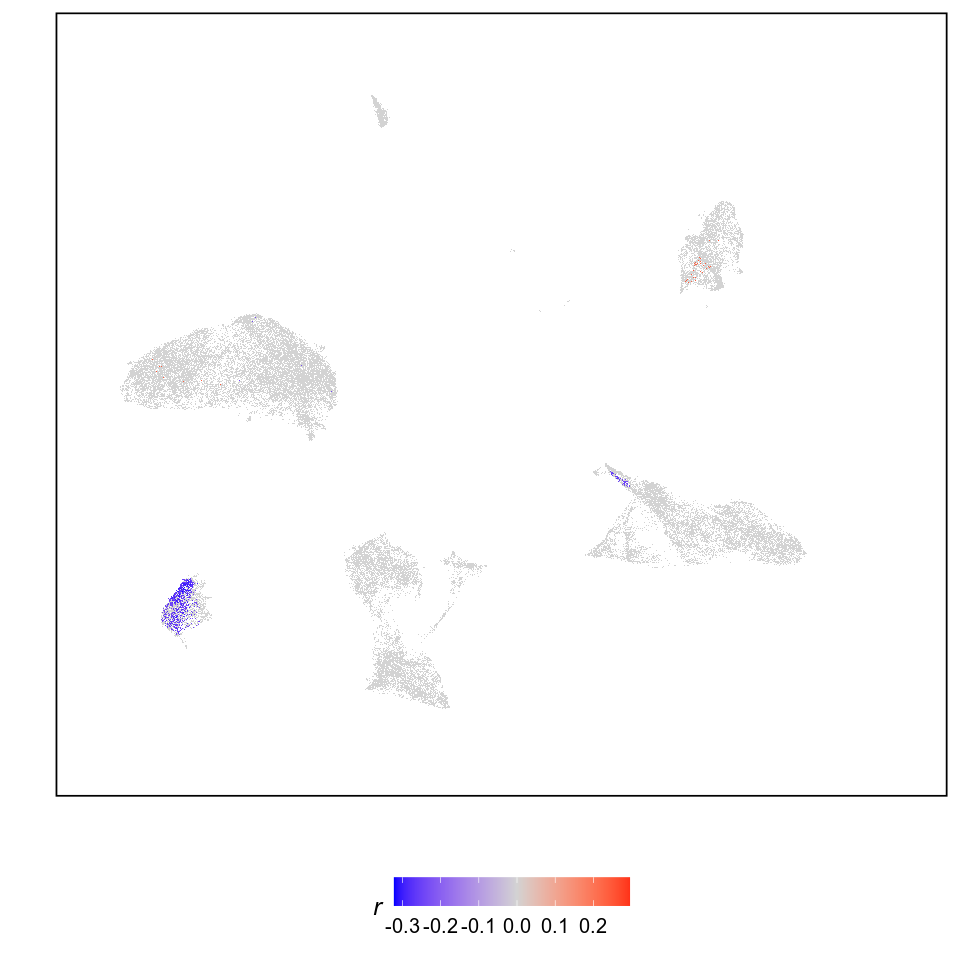

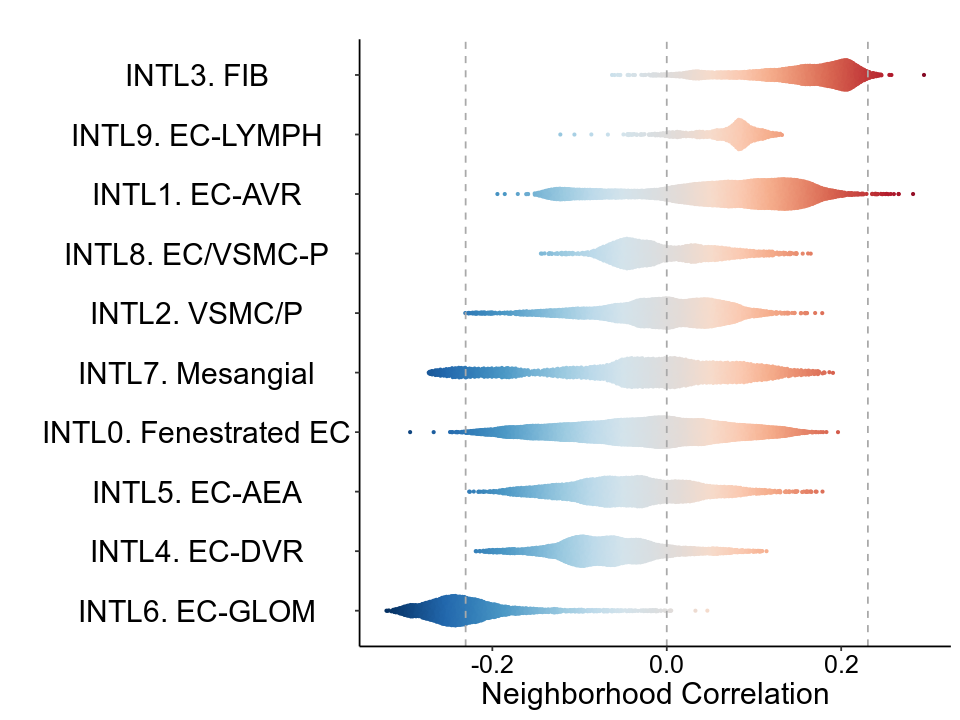

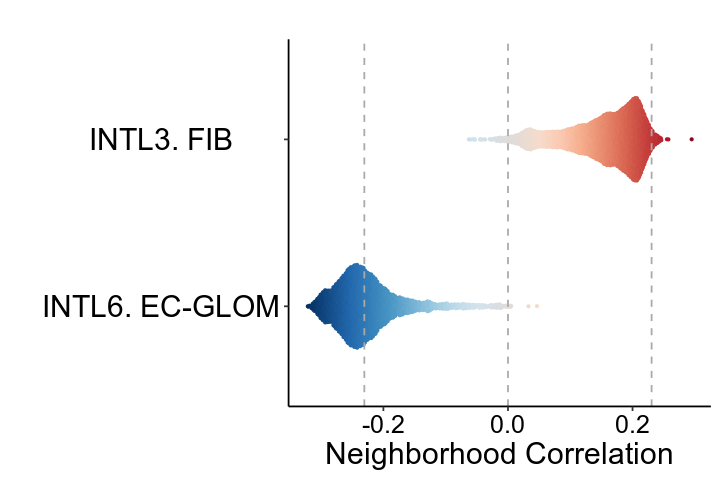

In [23]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/chronicity/sc_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/chronicity/sc_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/chronicity/sc_conditional_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/chronicity/sc_conditional_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr_5 <- fdrs %>% filter(fdr < 0.05) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% 
                    mutate(ncorr = ifelse(abs(meta$ncorr) > fdr_5, ncorr, NA)) 
tmp_meta <- tmp_meta %>% cbind(umap)

fig.size(8, 8)
ggplot() + 
      geom_point(data = intl_meta,
                 aes(x = huwotUMAP1, y = huwotUMAP2), color = 'lightgrey',
                    size = 0.1, shape = 20, stroke = 0.0001) +
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = huwotUMAP1, y = huwotUMAP2, color = correlation),
          size = 0.1, shape = 20, stroke = 0.0001
) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
theme_classic(base_size = 15) +
labs(x = "", y = "", color = "r") + 
  theme(
    legend.position = "bottom",
      legend.key.width = unit(1, "cm"),
          plot.title = element_text(hjust = 0.5, 
                                    size = 18, 
                                    face = "bold"),
          axis.title = element_text(hjust = 0.75, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          legend.title = element_text(face = "italic"),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +
scale_x_continuous(limits = c(-10, 15)) +
scale_y_continuous(limits = c(-12, 15))

pos_fdr_thresh <- fdr_5
neg_fdr_thresh <- -1 * fdr_5

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(6,8)

cluster_order <- meta %>% select(final_annotation, ncorr) %>% 
                    group_by(final_annotation) %>% summarize(ncorr = mean(ncorr)) %>% 
                    arrange(ncorr) %>% pull(final_annotation)

ggplot(meta, aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
 #   scale_x_discrete(limits = cluster_order) +
    labs( x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))
fig.size(4, 6)
ggplot(meta %>% filter(final_annotation %in% c("INTL6. EC-GLOM", "INTL3. FIB")), aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
 #   scale_x_discrete(limits = cluster_order) +
    labs( x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

In [ ]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/chronicity/sn_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/chronicity/sn_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/chronicity/sn_conditional_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/chronicity/sn_conditional_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr_5 <- fdrs %>% filter(fdr < 0.05) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% 
                    mutate(ncorr = ifelse(abs(meta$ncorr) > fdr_5, ncorr, NA)) 
tmp_meta <- tmp_meta %>% cbind(umap)

fig.size(8, 8)
ggplot() + 
      geom_point(data = intl_meta,
                 aes(x = huwotUMAP1, y = huwotUMAP2), color = 'lightgrey',
                    size = 0.1, shape = 20, stroke = 0.0001) +
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = huwotUMAP1, y = huwotUMAP2, color = correlation),
          size = 0.1, shape = 20, stroke = 0.0001
) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
      theme_bw(base_size = 15) +
  theme( legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", hjust = 0.5, face = "bold", size=20)
  ) +
scale_x_continuous(limits = c(-10, 15)) +
scale_y_continuous(limits = c(-12, 15))

pos_fdr_thresh <- fdr_5
neg_fdr_thresh <- -1 * fdr_5

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(8, 16)

cluster_order <- meta %>% select(final_annotation, ncorr) %>% 
                    group_by(final_annotation) %>% summarize(ncorr = mean(ncorr)) %>% 
                    arrange(ncorr) %>% pull(final_annotation)

ggplot(meta, aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
 #   scale_x_discrete(limits = cluster_order) +
    labs( x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

In [59]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/chronicity/sc_meta.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/chronicity/sc_conditional_ncorr.csv", header = FALSE)
meta$ncorr <- ncorr$V1

final_annotation = data.frame(hres.0.4 = seq(0, 9),
                                 final_annotation = c("INTL0. Fenestrated EC",
                                                      "INTL1. EC-AVR",
                                                      "INTL2. VSMC/P",
                                                      "INTL3. FIB",
                                                      "INTL4. EC-DVR",
                                                      "INTL5. EC-AEA",
                                                      "INTL6. EC-GLOM",
                                                      "INTL7. Mesangial",
                                                      "INTL8. EC/VSMC-P",
                                                      "INTL9. EC-LYMPH"))

meta <- left_join(meta, 
                  final_annotation) %>% 
                  mutate(new_cluster_number = hres.0.4)

ci_summary <- meta %>% 
                select(new_cluster_number, cell, ncorr) %>% 
                group_by(new_cluster_number) %>% 
                summarize(ncorr.ci = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(cell)), 3),
                                      ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(cell)), 3), ")"))
res <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/masc/INTL/chronicity_covariates.rds') %>% 
        mutate(new_cluster_number = as.numeric(str_remove(cluster, "cluster")),
               OR.ci = paste0("(", round(Final_Chronicity.OR.95pct.ci.lower, 3), ", ", 
                              round(Final_Chronicity.OR.95pct.ci.upper, 3), ")")) %>% 
        select(new_cluster_number, OR.ci)

summary <- ci_summary %>% left_join(res)
write.table(summary, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/intl_chronicity_corr_04152024.csv', quote = FALSE, row.names = FALSE,
            sep = "\t")

Joining, by = "final_annotation"
Joining, by = "new_cluster_number"


### MASC

In [13]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/chronicity/sc_meta.csv')

model_df <- meta %>% 
                left_join(intl_meta %>% select(cell,  hres.0.4)) 

res <- MASC.me(model_df, as.factor(model_df$hres.0.4),
                contrast = "Final_Chronicity",
                random_effects = c("sample"),
                fixed_effects = c('First_biop', 'Responder_Status'),
                verbose = TRUE,
                save_models = F) %>%
            dplyr::mutate(bonferroni = p.adjust(model.pvalue, method = "bonferroni")) %>%
            dplyr::arrange(model.pvalue)

Joining, by = "cell"
Using null model: cluster ~ First_biop + Responder_Status + (1|sample)

Creating logistic mixed models for cluster0



ERROR: Error in glmerControl(optimizer = "bobyqa"): could not find function "glmerControl"


In [ ]:
saveRDS(res, '/data/srlab/ssg34/SLE_kidney_v2/data/masc/INTL/chronicity_covariates.rds')

In [15]:
res <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/masc/INTL/chronicity_covariates.rds')

In [16]:
res <-  res %>% 
            rowwise() %>% 
            mutate(cluster = paste0("INTL", unlist(str_split(cluster, 'cluster'))[2]))

Warning message:
“Removed 8 rows containing missing values (`geom_label_repel()`).”


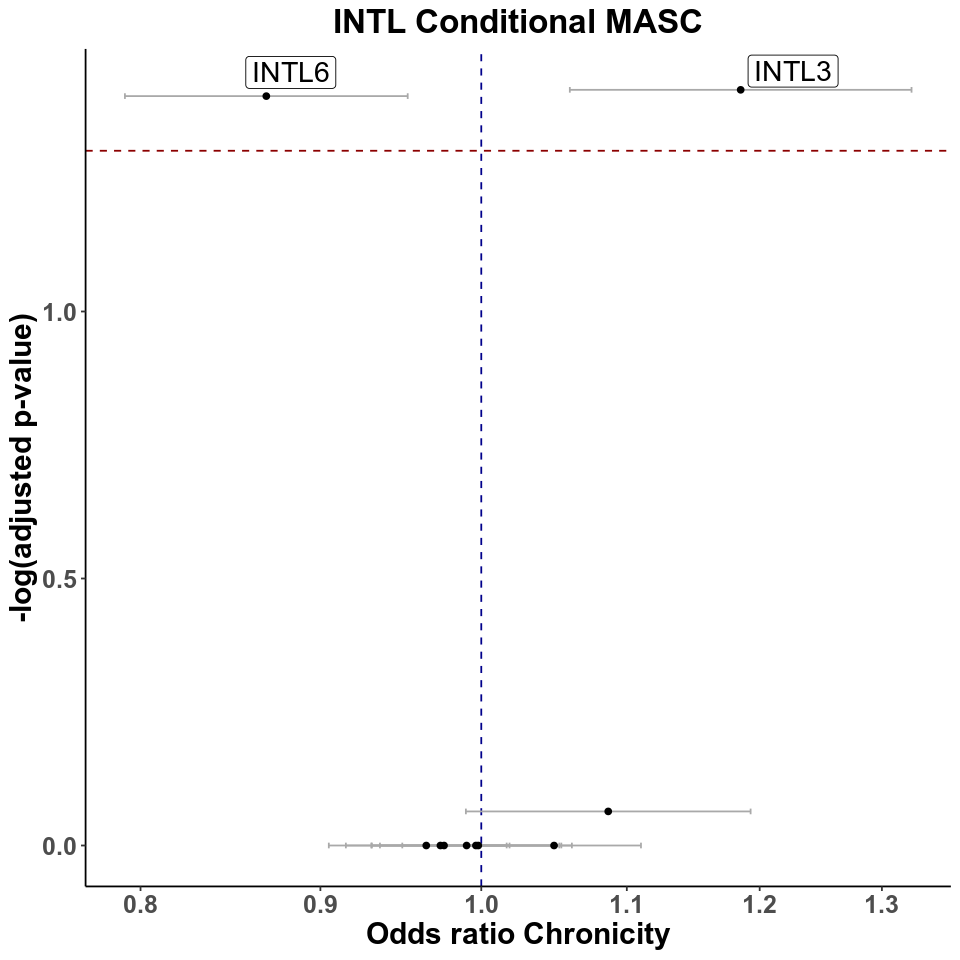

In [17]:
fig.size(8, 8)

ggplot(data = res %>% mutate(label = ifelse(-log10(model.pvalue) > -log10(0.05), cluster, NA)), 
       aes(x = Final_Chronicity.OR, y = -log10(bonferroni))) +
    theme_classic() + ylab("-log(adjusted p-value)") + xlab("Odds ratio Chronicity") +
    labs(title = "INTL Conditional MASC") + 
    geom_vline(xintercept = 1, linetype = "dashed", color = "darkblue") +
    geom_errorbar(aes(xmin=Final_Chronicity.OR.95pct.ci.lower, xmax=Final_Chronicity.OR.95pct.ci.upper), col = "darkgrey") +
    geom_point() + 
    geom_hline(yintercept = -log10(.05), linetype = "dashed", color = "darkred") +
    scale_x_log10(breaks = c(0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3 ,1.4)) + 
    ggrepel::geom_label_repel(aes(label = label), size = 6) +
    theme(axis.title = element_text(size = 18, face = "bold"),
          axis.text = element_text(size = 15, face = "bold"),
          plot.title = element_text(size = 20, hjust = 0.5, face = "bold"))

### DE

In [69]:
de <- function(feature, df) {
    model_df <- df %>% select(feature, sample, First_biop, Responder_Status, 
                              Final_Chronicity, avg_count, avg_mt) %>% rename(Exp = feature)
    if (sum(model_df$Exp > 0) > 0.05 * nrow(model_df)) { 
        m_0 <- lm(Exp ~ log(avg_count) + avg_mt, data = model_df)
        m_1 <- lm(Exp ~ log(avg_count) + avg_mt + Final_Chronicity, data = model_df)
        ANNO <- anova(m_0, m_1)
        LRP <- ANNO[2,6]
        F <- ANNO[2,5]
        Beta <- summary(m_1)$coefficients['Final_Chronicity', 'Estimate']
        SE <- summary(m_1)$coefficients['Final_Chronicity', 'Std. Error']
        res <- c(gene = feature, LRP = LRP, F = F, Beta = Beta, SE = SE)
    }
    else {
        res <- c(gene = feature, LRP = NA, F = NA, Beta = NA, SE = NA)
    }
    return(res)
}

In [71]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/chronicity/sc_meta.csv')
intl_pb <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/INTL_norm_pseudobulk_12072023.rds')

In [72]:
intl_pb <- intl_pb %>% 
                filter(sample %in% unique(meta$sample)) %>% 
                left_join(meta %>% 
                              select(sample, First_biop, Responder_Status, Final_Chronicity) %>% 
                              unique())

Joining, by = "sample"


In [73]:
de_out <- mclapply(colnames(intl_pb)[1:36601], de, intl_pb, mc.cores = 20)

In [74]:
de_df <- data.frame(do.call(rbind, de_out)) %>% mutate(LRP = as.numeric(LRP),
                                                       F = as.numeric(F),
                                                       Beta = as.numeric(Beta),
                                                       SE = as.numeric(SE))

In [118]:
saveRDS(de_df, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/INTL_chronicity_differential_expression_03082024.rds')

In [84]:
de_df <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/INTL_chronicity_differential_expression_03082024.rds')

In [85]:
de_df <- de_df %>% 
            na.omit() %>% 
            arrange(LRP) %>% 
            mutate(FDR = p.adjust(LRP, method = "BH")) 

In [86]:
de_df %>% filter(FDR < 0.05) %>% arrange(Beta) %>% slice(1:20)

gene,LRP,F,Beta,SE,FDR
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IFI6,9.526238e-05,16.19813,-0.16471795,0.04092687,4.710452e-03
IGFBP2,2.951046e-10,46.46718,-0.14752236,0.02164137,1.104134e-06
PODXL,4.671459e-05,17.72434,-0.12233508,0.02905802,2.826674e-03
PTGDS,8.815112e-05,16.36323,-0.11048248,0.02731234,4.427080e-03
NPHS2,2.894531e-05,18.76169,-0.11030159,0.02546513,2.043375e-03
SPOCK2,2.234406e-09,41.19828,-0.10493868,0.01634918,2.950599e-06
CDKN1C,1.082907e-05,20.92251,-0.10345631,0.02261779,1.084818e-03
VEGFA,1.102813e-06,26.09566,-0.10344036,0.02024911,2.250640e-04
CLIC5,1.095038e-08,37.17969,-0.10130857,0.01661473,8.476727e-06


In [91]:
genes <- c("MMP7", "SPP1", "WFDC2", "KRT7", "TNFSF10",
           "IFI6", "ISG15", "SPOCK2",  "IGFBP2", "VEGFA")

Warning message:
“Removed 21642 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 740 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


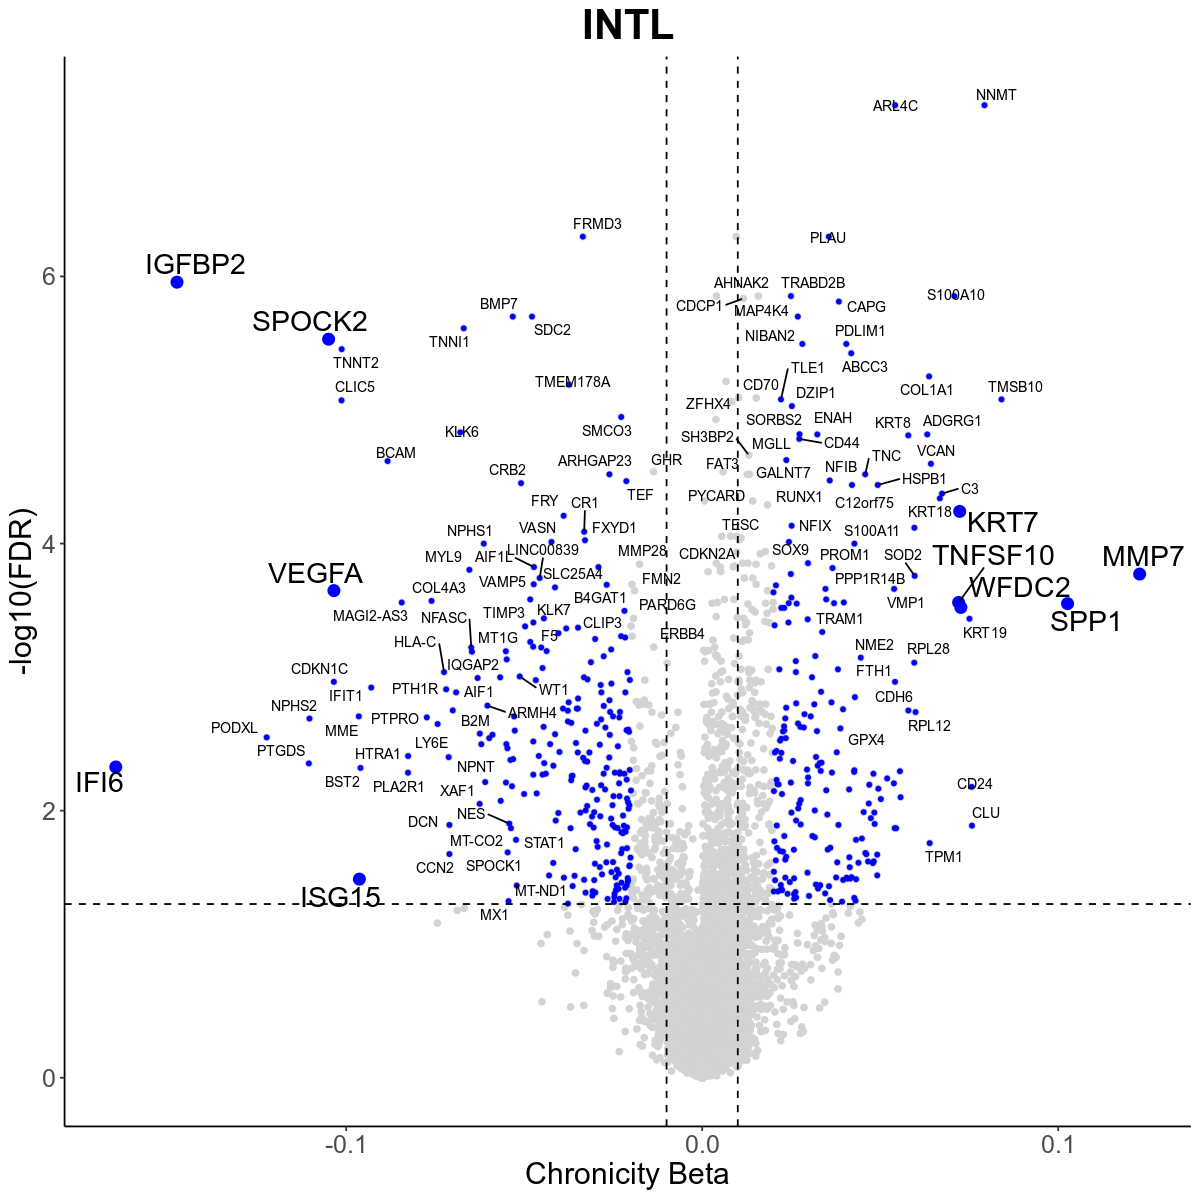

In [92]:
fig.size(10, 10)
ggplot(de_df,
                aes(x = Beta, y = -log10(FDR))) +
    geom_point(colour = 'lightgrey') + 
    geom_point(data = de_df %>% filter(FDR < 0.05 & abs(Beta) >= 0.02,
                                        ! gene %in% genes),
                   aes(x = Beta, y = -log10(FDR)),  color = "blue", size = 1) +
    geom_point(data = de_df %>% filter(gene %in% genes),
                   aes(x = Beta, y = -log10(FDR)),  color = "blue", size = 3)  + 
    geom_vline(xintercept = c(-0.01, 0.01), linetype = "dashed") + 
    geom_hline(yintercept = -log10(0.05), linetype = "dashed") + 
    theme_classic() + 
    theme(legend.position = "none",
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 25, hjust = 0.5, face = "bold")) +
    ggrepel::geom_text_repel(data = de_df %>% 
                                     mutate(label = ifelse(FDR < 0.05 & abs(Beta) >= 0.01 | 
                                                           gene %in% genes, gene, NA),
                                            label_size = ifelse(gene %in% genes, 6 , 3)),
                                     aes(x = Beta, y = -log10(FDR), 
                                         size = label_size, label = label)
            , color = "black") +
    scale_size_identity() + 
    labs(x = "Chronicity Beta", y = "-log10(FDR)", title = "INTL")

## ACTIVITY

In [15]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_Activity)]
meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/activity/sc_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/activity/sc_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/activity/sc_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [16]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))

harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_Activity)]
meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/activity/sn_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/activity/sn_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/activity/sn_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


## ISN

In [36]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_ISN)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")
write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/ISN/sc_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/ISN/sc_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/ISN/sc_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [37]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_ISN)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")
write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/ISN/sn_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/ISN/sn_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/ISN/sn_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


## % INJURED PT

In [7]:
lateinjury_high_prop <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/injured_pt_highprop_singlecell_05102024.rds') %>% 
                            select(Prop, sample)

In [9]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

meta <- meta %>% left_join(lateinjury_high_prop %>% rename(injured_pt_prop = Prop))

ind <- c(1:nrow(meta))[!is.na(meta$injured_pt_prop)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)


meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/injured_pt/sc_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/injured_pt/sc_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/injured_pt/sc_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "sample"
Joining, by = "Responder.Status"


In [10]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

meta$individual <- str_remove(meta$sample, "AMPSLEkid_nuc_")

meta <- meta %>% 
            left_join(lateinjury_high_prop %>% 
                       ungroup() %>% 
                       rename(injured_pt_prop = Prop) %>% 
                       mutate(individual = str_remove(as.character(sample), 
                                                      "AMPSLEkid_cells_")) %>%
                       select(individual, injured_pt_prop))


ind <- c(1:nrow(meta))[!is.na(meta$injured_pt_prop)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)


meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/injured_pt/sn_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/injured_pt/sn_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/injured_pt/sn_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "individual"
Joining, by = "Responder.Status"


### RESULTS

In [4]:
pt_meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/injured_pt/sc_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/injured_pt/sc_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/injured_pt/sc_cond_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/injured_pt/sc_cond_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
pt_meta$ncorr <- ncorr$V1

meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/chronicity/sc_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/chronicity/sc_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/chronicity/sc_conditional_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/chronicity/sc_conditional_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

In [5]:
ncorr_meta <- pt_meta %>% 
                    select(cell, ncorr) %>% 
                    rename(pt_ncorr = ncorr) %>% 
                left_join(meta %>% 
                            select(cell, ncorr) %>% 
                            rename(chronicity_ncorr = ncorr)) %>% na.omit()

Joining, by = "cell"


[1] 0.170049

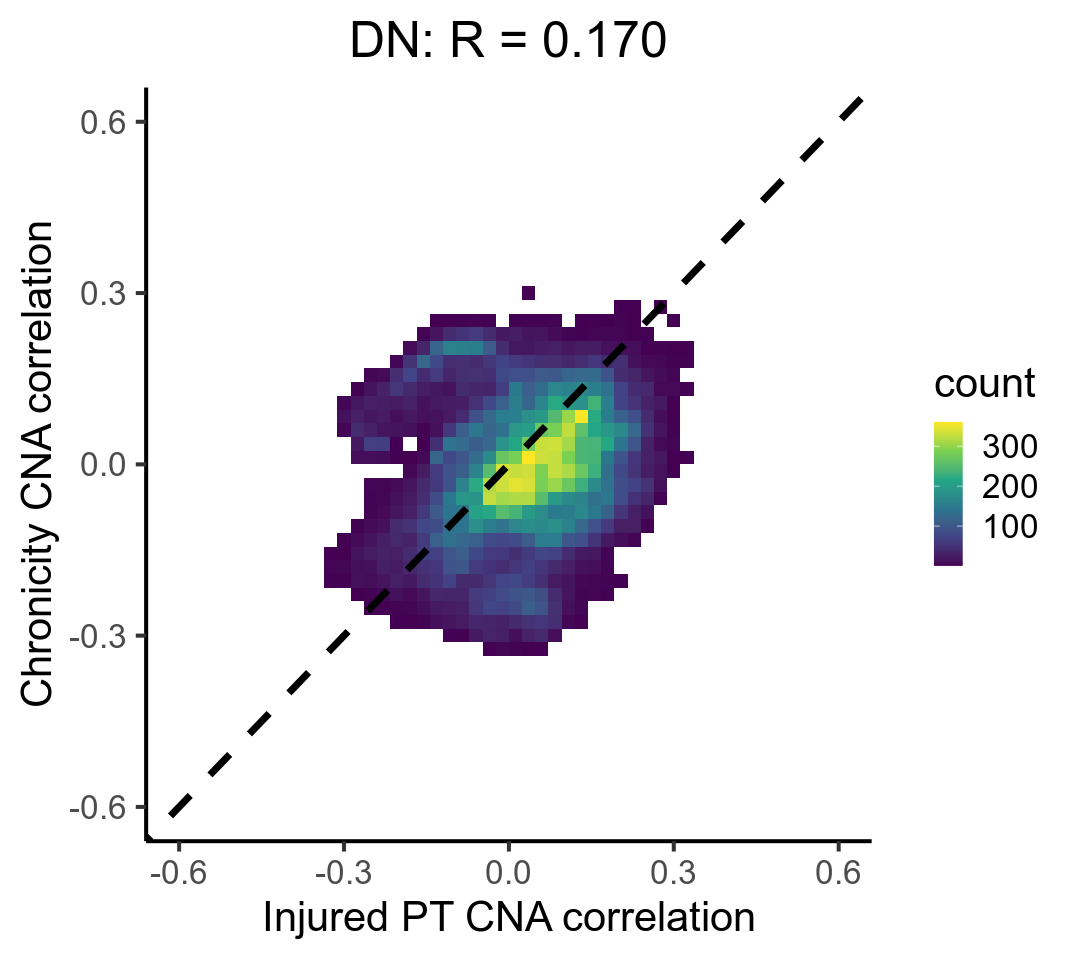

In [9]:
fig.size(8, 9)
cor(ncorr_meta$pt_ncorr, ncorr_meta$chronicity_ncorr)
cor_plot <- ggplot(ncorr_meta, aes(x = pt_ncorr, y = chronicity_ncorr)) +
                    geom_bin2d(bins = 50) +
                    scale_fill_continuous(type = "viridis",
                                          breaks = c(100, 200, 300, 400)) +
                   theme_classic(base_size = 25) +
                    geom_abline(linetype = 'dashed', linewidth = 2) + 
                    scale_x_continuous(limits = c(-0.6, 0.6)) + 
                    scale_y_continuous(limits = c(-0.6, 0.6)) + 
                    labs(x = "Injured PT CNA correlation",
                         y = "Chronicity CNA correlation",
                         title = "DN: R = 0.170") + 
                    theme(
                          plot.title = element_text(size = 30, 
                                                    hjust = 0.5),
                            text=element_text(family="Arial"))
cor_plot
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/main_figures/figure6/figure6h.png",
       cor_plot,
       base_height = 8,
       base_width = 9)

### CNA

In [2]:
options(warn=-1)
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/injured_pt/sc_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/injured_pt/sc_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/injured_pt/sc_cond_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/injured_pt/sc_cond_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1


fdr <- fdrs %>% 
            filter(fdr < 0.05) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% mutate(ifelse(abs(meta$ncorr) > fdr, ncorr, NA))
tmp_meta <- cbind(tmp_meta, umap)

fig.size(8, 8)
cna_umap <- ggplot() + 
      geom_point(data = tmp_meta,
                aes(x = huwotUMAP1, y = huwotUMAP2), color = 'lightgrey', size = 0.75, stroke = 0.0001, shape = 20) + 
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = huwotUMAP1, y = huwotUMAP2, color = correlation), size = 0.75, stroke = 0.0001, shape = 20) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
     # labs(x="UMAP1", y="UMAP2", title = "Myeloid Chronicity: p = 2.00e-04") +
theme_classic(base_size = 15) +
      theme(
        legend.position = "right",
            #  plot.title = element_text(hjust = 0.5, 
            #                            size = 18, 
            #                            face = "bold"),
              axis.title = element_text(hjust = 0.75, 
                                        size = 20, 
                                        face = "bold"), 
              axis.text = element_blank(),
              axis.line = element_blank(),
              axis.ticks = element_blank(),
              panel.border = element_rect(colour = "black", fill=NA, size=1)
    ) +
        labs(x = "UMAP1", y = "UMAP2") + 
    theme(text=element_text(family="Arial")) 
umap_legend <- cowplot::get_legend(cna_umap)
cna_umap <- cna_umap + theme(legend.position = "none")
umap_legend <- cowplot::plot_grid(umap_legend)
fig.size(10, 10)
cna_umap
fig.size(3, 3)
umap_legend

cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/supplemental_figures/figure6/figure6g-cna_umap.png",
       cna_umap,
       base_height = 10,
       base_width = 10)
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/supplemental_figures/figure6/figure6g-cna_umap_legend.png",
       umap_legend,
       base_height = 3,
       base_width = 3)
options(warn=0)

subset <- c('INTL0. Fenestrated EC', 'INTL8. EC/VSMC-P')
violin_plot <- ggplot(meta %>% filter(final_annotation %in% subset), aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
                    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
                    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
                    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
                    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
                    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
                    labs( x= "Neighborhood Correlation", y = "", title = "") +
                    theme_classic(base_size = 30) +
                    theme(text=element_text(family="Arial"),
                        legend.position = "none",
                        panel.grid = element_blank(),
                        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
                        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
                        axis.title = element_text(size=18, hjust = 0.5),
                        axis.line.x.bottom = element_line(color = 'black', linewidth = 1),
                        axis.line.y.left   = element_line(color = 'black', linewidth = 1))
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/main_figures/figure6/figure6g-violin_plot.png",
       violin_plot,
       base_height = 6,
       base_width = 10)
options(warn=0)

ERROR: [1m[33mError[39m in `mutate()`:[22m
[1m[22m[33m![39m Problem while computing `..1 = ifelse(abs(meta$ncorr) > fdr, ncorr, NA)`.
[31m✖[39m `..1` must be size 43965 or 1, not 0.


In [39]:
fdrs %>% filter(fdr < 0.1)

threshold,fdr,ncells
<dbl>,<dbl>,<dbl>


### MASC

In [ ]:
intl_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/intl_meta_qcd_harmony_umap_clusternames_11302023.rds')
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/injured_pt/sc_meta.csv')

model_df <- meta %>% 
                left_join(intl_meta %>% select(cell,  hres.0.4, nCount_RNA, percent.mt)) %>% 
                mutate(nCount_RNA = log(nCount_RNA))

res <- MASC.me(model_df, as.factor(model_df$hres.0.4),
                contrast = "injured_pt_prop",
                random_effects = c("sample"),
                fixed_effects = c("nCount_RNA", 
                                  "percent.mt"),
                verbose = TRUE,
                save_models = F) %>%
            dplyr::mutate(bonferroni = p.adjust(model.pvalue, method = "bonferroni")) %>%
            dplyr::arrange(model.pvalue)
saveRDS(res, '/data/srlab/ssg34/SLE_kidney_v2/data/masc/INTL/injured_pt.rds')

In [12]:
intl_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/intl_meta_qcd_harmony_umap_clusternames_11302023.rds')
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/injured_pt/sc_meta.csv')

model_df <- meta %>% 
                left_join(intl_meta %>% select(cell,  hres.0.4, nCount_RNA, percent.mt)) %>% 
                mutate(nCount_RNA = log(nCount_RNA))

res <- MASC.me(model_df, as.factor(model_df$hres.0.4),
                contrast = "injured_pt_prop",
                random_effects = c("sample"),
                fixed_effects = c("nCount_RNA", 
                                  "percent.mt", 
                                  'Final_Site_JHU',
                                  'Final_Site_NYU',
                                  'First_biop',
                                  'Responder_Status',
                                  'Age', 
                                  'Final_Chronicity'),
                verbose = TRUE,
                save_models = F) %>%
            dplyr::mutate(bonferroni = p.adjust(model.pvalue, method = "bonferroni")) %>%
            dplyr::arrange(model.pvalue)
saveRDS(res, '/data/srlab/ssg34/SLE_kidney_v2/data/masc/INTL/injured_pt_cond.rds')

Joining, by = "cell"
Using null model: cluster ~ nCount_RNA + percent.mt + Final_Site_JHU + Final_Site_NYU + First_biop + Responder_Status + Age + Final_Chronicity + (1|sample)

Creating logistic mixed models for cluster0

Creating logistic mixed models for cluster1

Creating logistic mixed models for cluster2

Creating logistic mixed models for cluster3

Creating logistic mixed models for cluster4

Creating logistic mixed models for cluster5

Creating logistic mixed models for cluster6

Creating logistic mixed models for cluster7

Creating logistic mixed models for cluster8

Creating logistic mixed models for cluster9



In [28]:
res$cluster <- paste0("INTL", as.numeric(gsub("\\D", "", res$cluster)))

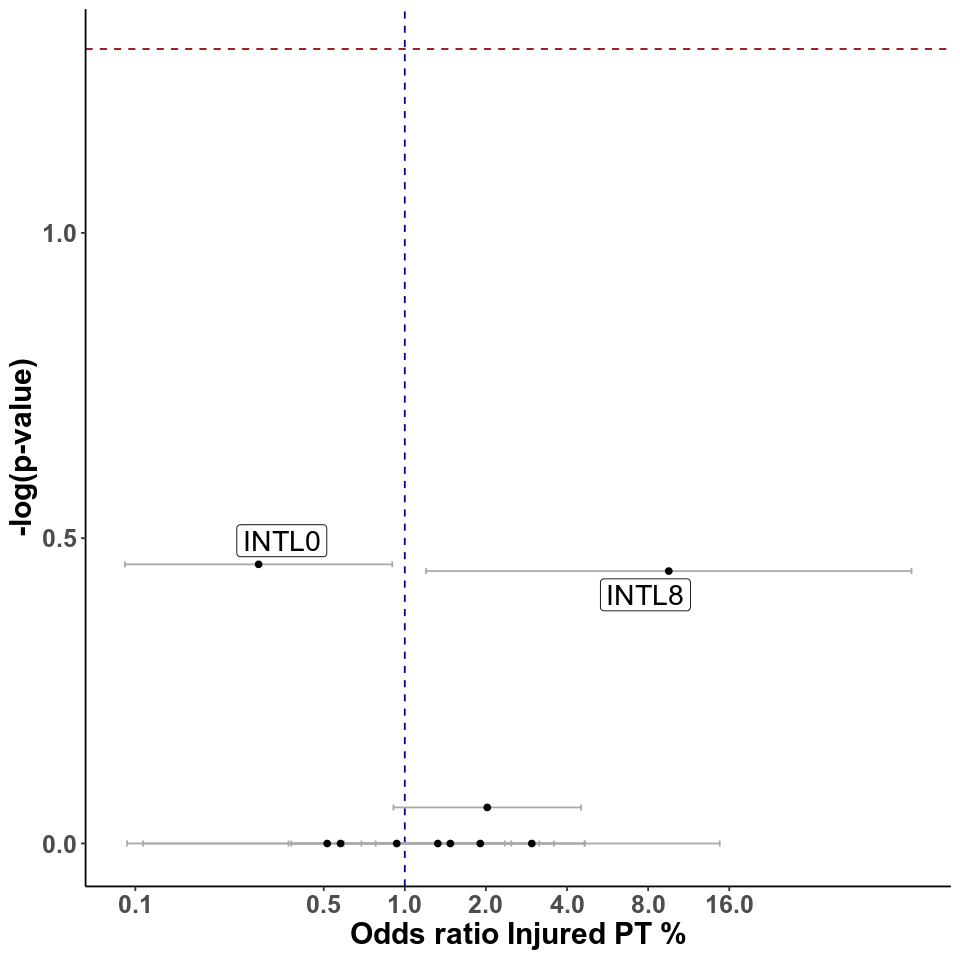

In [4]:
res <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/masc/INTL/injured_pt_cond.rds')
res$cluster <- paste0("INTL", as.numeric(gsub("\\D", "", res$cluster)))
fig.size(8, 8)
masc_plot <- ggplot(data = res %>% 
                   mutate(label = ifelse(model.pvalue < 0.05, cluster, NA)), 
       aes(x = injured_pt_prop.OR, y = -log10(bonferroni))) +
    theme_classic() + ylab("-log(p-value)") + xlab("Odds ratio Injured PT %") +
    geom_vline(xintercept = 1, linetype = "dashed", color = "darkblue") +
    geom_errorbar(aes(xmin=injured_pt_prop.OR.95pct.ci.lower, 
                      xmax=injured_pt_prop.OR.95pct.ci.upper), col = "darkgrey") +
    geom_point() + 
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "darkred") +
    scale_x_log10(breaks = c(0.1, 0.5, 1, 2, 4, 8, 16)) + 
    ggrepel::geom_label_repel(aes(label = label), size = 6) +
    theme(text=element_text(family="Arial"),
          axis.title = element_text(size = 18, face = "bold"),
          axis.text = element_text(size = 15, face = "bold"))
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/supplemental_figures/figure10/figure10c.png",
       masc_plot,
       base_height = 8,
       base_width = 8)
masc_plot

### DE

In [10]:
de <- function(feature, df) {
    model_df <- df %>% select(feature, sample,  
                              injured_pt_prop, avg_count, avg_mt) %>% rename(Exp = feature)
    if (sum(model_df$Exp > 0) > 0.1 * nrow(model_df)) { 
        m_0 <- lm(Exp ~ log(avg_count) + avg_mt, data = model_df)
        m_1 <- lm(Exp ~ log(avg_count) + avg_mt + injured_pt_prop, data = model_df)
        ANNO <- anova(m_0, m_1)
        LRP <- ANNO[2,6]
        F <- ANNO[2,5]
        Beta <- summary(m_1)$coefficients['injured_pt_prop', 'Estimate']
        SE <- summary(m_1)$coefficients['injured_pt_prop', 'Std. Error']
        res <- c(gene = feature, LRP = LRP, F = F, Beta = Beta, SE = SE)
    }
    else {
        res <- c(gene = feature, LRP = NA, F = NA, Beta = NA, SE = NA)
    }
    return(res)
}

In [11]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/INTL/injured_pt/sc_meta.csv')
intl_pb <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/INTL_norm_pseudobulk_12072023.rds')

In [12]:
intl_pb <- intl_pb %>% 
                filter(sample %in% unique(meta$sample)) %>% 
                left_join(meta %>% 
                              select(sample, First_biop, Responder_Status, injured_pt_prop) %>% 
                              unique())

Joining, by = "sample"


In [13]:
de_out <- mclapply(colnames(intl_pb)[1:36601], de, intl_pb, mc.cores = 20)
de_df <- data.frame(do.call(rbind, de_out)) %>% mutate(LRP = as.numeric(LRP),
                                                       F = as.numeric(F),
                                                       Beta = as.numeric(Beta),
                                                       SE = as.numeric(SE))

In [14]:
saveRDS(de_df, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/INTL_injured_pt_differential_expression_03082024.rds')

In [15]:
de_df <- de_df %>% 
            na.omit() %>% 
            arrange(LRP) %>% 
            mutate(FDR = p.adjust(LRP, method = "BH")) 